In [50]:
#Always make all imports in the first cell of the notebook, run them all once.
import cv2
import numpy as np
import math
import glob
import skimage
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.filters.rank import otsu
from skimage.filters import median, threshold_otsu
# import import_ipynb
# import Utilities
%run Utilities.ipynb
%run LineSegmentor.ipynb
%matplotlib inline

In [51]:
class Preprocessor:
    @staticmethod
    def read_images(fileName, imagesIDs):
            #fileName = fileName + '/*png'
            x_train = []
            x_images_names = []
            for imageID in imagesIDs:
                img = cv2.imread(fileName+'/'+imageID) ## cv2.imread reads images in RGB format
                x_images_names.append(imageID)
                x_train.append(img)
            x_train = np.asarray(x_train)
            return x_train, x_images_names

    @staticmethod    
    def preprocess(img):
        # Reduce image noise.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.GaussianBlur(img, (5, 5), 0)


        # Binarize the image.
        # _,thresholded_img =  cv2.threshold(img, 165,255,cv2.THRESH_BINARY)
        _,thresholded_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Return pre processed images.
        return thresholded_img
    
    
    @staticmethod
    def crop(img):
        # Converting the image to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)
        
        
        # Finding all contours in the image
        contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        
        #image = cv2.drawContours(image, contours, -1, (0, 255, 0), 2)


        # Minimum contour width to be considered as the black separator line.
        threshold_width = 1000
        line_offset = 0
        
        
        # Page paragraph boundaries.
        height, width = gray.shape
        up, down, left, right = 0, height - 1, 0, width - 1

        # Detect the main horizontal black separator lines of the IAM handwriting forms.
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w < threshold_width:
                continue
            if y < height // 2:
                up = max(up, y + h + line_offset)
            else:
                down = min(down, y - line_offset)
   
        # Applying filters to enhance the image    
        kernel = np.ones((3, 3), np.uint8)
        eroded_img = cv2.erode(binary, kernel, iterations=2)
        # Get horizontal and vertical histograms.
        hor_hist = np.sum(eroded_img, axis=1) / 255
        ver_hist = np.sum(eroded_img, axis=0) / 255

        # Detect paragraph white padding.
        while left < right and ver_hist[left] == 0:
            left += 1
        while right > left and ver_hist[right] == 0:
            right -= 1
        while up < down and hor_hist[up] == 0:
            up += 1
        while down > up and hor_hist[down] == 0:
            down -= 1
            
        gray = gray[up:down + 1, left:right + 1]
        binary = binary[up:down + 1, left:right + 1]
        
        return gray, binary


    @staticmethod
    def save_preprocessed(fileName, x_images_names, x_train_gray,x_train_binary,writer_id):
        gray_directory='PreprocessedImages/'+writer_id+'/gray/'
        binary_directory='PreprocessedImages/'+writer_id+'/binary/'
        if not os.path.exists(fileName +gray_directory):
            os.makedirs(fileName +gray_directory)
        if not os.path.exists(fileName +binary_directory):
            os.makedirs(fileName +binary_directory)    
        for i in range(len(x_train_gray)):
#             print(fileName +'gray/' + str(x_images_names[i]))
#             print(fileName + 'binary/' + str(x_images_names[i]))
            cv2.imwrite(fileName +gray_directory + str(x_images_names[i]) ,x_train_gray[i])
            cv2.imwrite(fileName + binary_directory + str(x_images_names[i]),x_train_binary[i])
    
    @staticmethod
    def preprocessing_pipeline(fileName, imagesIDs,writer_id):
        x_train, x_images_names = Preprocessor.read_images(fileName, imagesIDs)
        x_train_gray = []
        x_train_binary = []
        for img in x_train:
            preprocessedImage = Preprocessor.preprocess(img)
            croppedImageGray, croppedImageBinary = Preprocessor.crop(preprocessedImage)
            x_train_gray.append(croppedImageGray)
            x_train_binary.append(croppedImageBinary)
        
        
        #Preprocessor.save_preprocessed(fileName, x_images_names, x_train_gray, x_train_binary,writer_id)
        return x_train_gray, x_train_binary 
            


In [52]:
def get_writers_images_names(file_path):
    try:
        file = open(file_path, "r")
        file_lines = file.readlines()
        for i in range(len(file_lines)):
            file_lines[i] = file_lines[i].rstrip("\n")
        file.close()
        return file_lines
    except IOError:
        return []

In [53]:
prep = Preprocessor()
z = '%03d' % 0
writerImagesID = get_writers_images_names("Data\Writers\\"+z+".txt")
x_train_gray, x_train_binary = prep.preprocessing_pipeline('Data/AllDataset',writerImagesID,z)


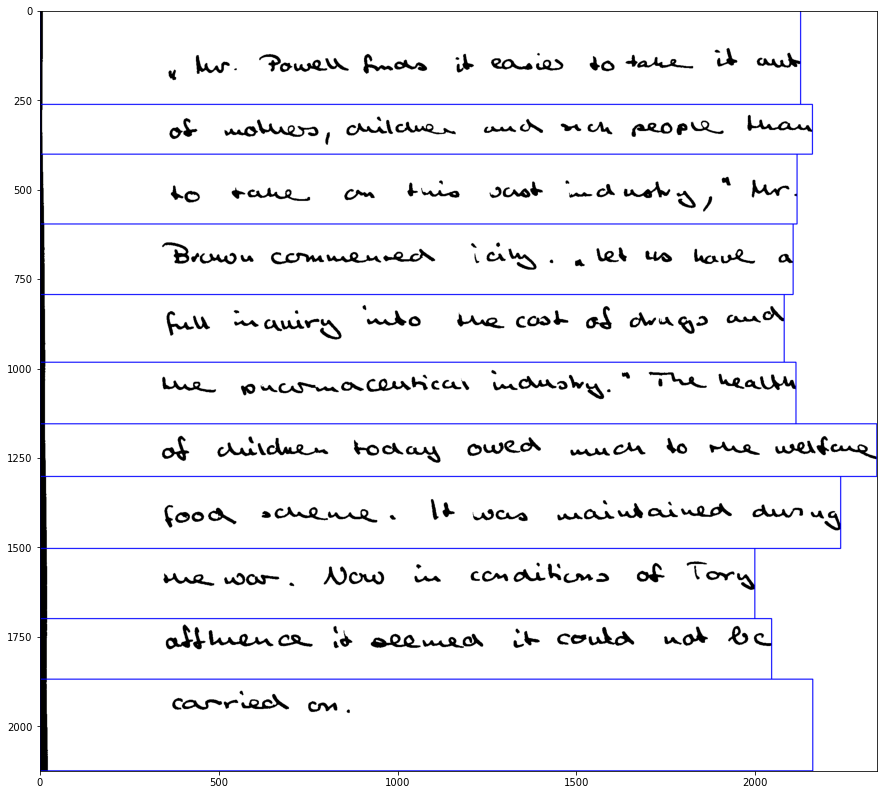

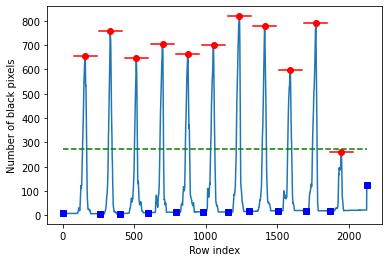

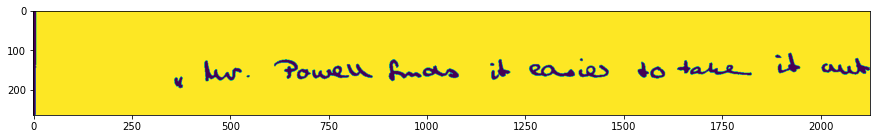

In [54]:
gray_img = x_train_gray[25]
bin_img = x_train_binary[25]
gray_lines, bin_lines = LineSegmentor(gray_img, bin_img).segment()

fig = plt.figure(figsize=(15,15))
plt.imshow(gray_lines[0])
plt.show()


In [55]:
# img = x_train[0]
# x=408
# y=746
# w=1661
# h=89
# cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
# fig = plt.figure(figsize=(15,15))
# plt.imshow(img)
# # show_images(x_train)